In [ ]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [ ]:
df = pd.read_csv('./nab/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv')

In [ ]:
print(df.info())

In [ ]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

matplotlib.pyplot.show()

In [ ]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [ ]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)


In [ ]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [ ]:
print(a_bins[:-1])
print(a_heights*100/a.count())
a_bins

In [34]:
# libraries
%matplotlib notebook

import pandas as pd
import numpy as np

import scipy as sc
# import custom_function as cf

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from fbprophet import Prophet

In [35]:
df=pd.read_csv('./nab/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv')

In [36]:
print(df['value'].mean())

71.2424327082882


<IPython.core.display.Javascript object>


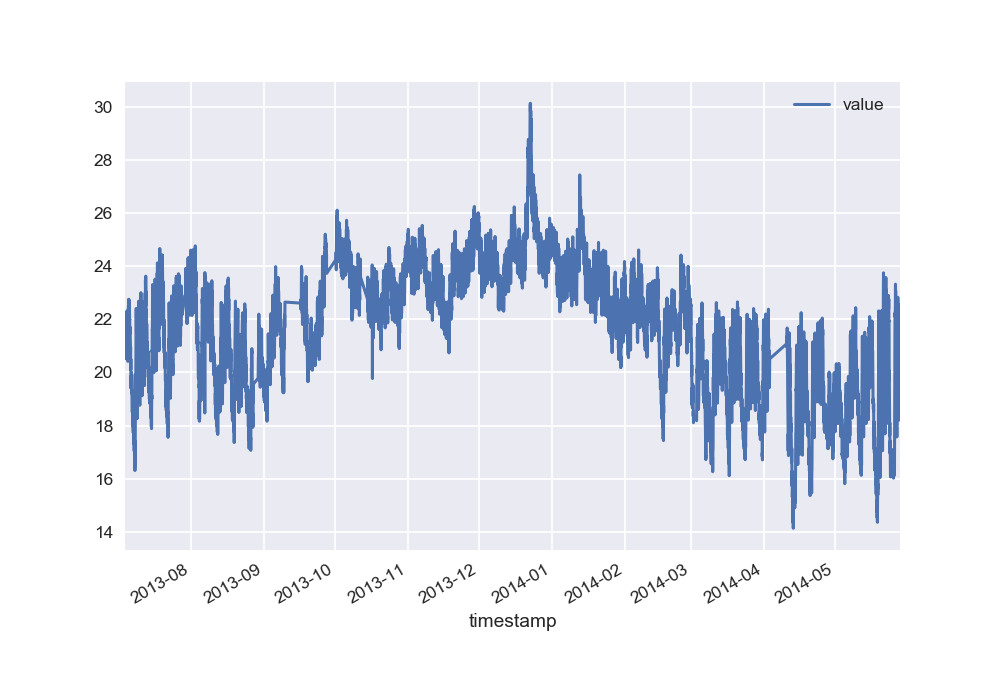

In [37]:
# getTransitionMatrix(df_mm)
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')


In [38]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [39]:
# some function for later
# return Series of distance between each point and his distance with the closest centroid



def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix
def successProbabilityMetric(state1, state2, transition_matrix):
    proba = 0
#     print('successProbabilityMetric-->transition_matrix')
#     print(transition_matrix)
    for k in range(0,len(transition_matrix)):
        if (k != (state2-1)):
            proba += transition_matrix[state1-1][k]
    print('successProbabilityMetric: %.4f' %(1-proba))
    print('successProbabilityMetric_new: %.4f' %(transition_matrix[state1-1][state2-1]))
    return 1-proba
def sucessScore(sequence, transition_matrix):
    proba = 0 
#     print('sequence')
#     print(sequence)
    for i in range(1,len(sequence)):
        if(i == 1):
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
    return proba
def anomalyElement(sequence, threshold, transition_matrix):
    if (sucessScore(sequence, transition_matrix) > threshold):
        return 0
    else:
        return 1
def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    print('real_threshold: %f' %(real_threshold))
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
            print(('j:%s, sequence:' %(j)))
            print(df_anomaly)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
#             if(j<10):
#                 print(('j:%s, sequence:' %(j)))
#                 print(df_anomaly)           
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly


# definition of the different state
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5



In [40]:
tmp=getTransitionMatrix(df_mm)
tmp

array([[  8.20809249e-01,   1.78227360e-01,   9.63391137e-04,
          0.00000000e+00,   0.00000000e+00],
       [  4.83786611e-02,   8.51464435e-01,   1.00156904e-01,
          0.00000000e+00,   0.00000000e+00],
       [  1.41083521e-04,   5.40349887e-02,   8.77257336e-01,
          6.85665914e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.94867682e-01,
          7.99518845e-01,   5.61347233e-03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.59090909e-01,   8.40909091e-01]])

In [22]:
tmp[1][2]

0.10015690376569038

In [33]:
markovAnomaly(df_mm, 10, 0.20)

real_threshold: 0.000000
j:0, sequence:
[0]
j:1, sequence:
[0, 0]
j:2, sequence:
[0, 0, 0]
j:3, sequence:
[0, 0, 0, 0]
j:4, sequence:
[0, 0, 0, 0, 0]
j:5, sequence:
[0, 0, 0, 0, 0, 0]
j:6, sequence:
[0, 0, 0, 0, 0, 0, 0]
j:7, sequence:
[0, 0, 0, 0, 0, 0, 0, 0]
j:8, sequence:
[0, 0, 0, 0, 0, 0, 0, 0, 0]
j:9, sequence:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMe

successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMe

successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.0540
successProbabilityMe

successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMe

successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMe

successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMe

successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMe

successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMe

successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMe

successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.1002
successProbabilityMe

successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.1949
successProbabilityMe

successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMe

successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMe

successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMe

successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMe

successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMe

successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMe

successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.0686
successProbabilityMetric_new: 0.0686
successProbabilityMetric: 0.1949
successProbabilityMetric_new: 0.1949
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMetric: 0.7995
successProbabilityMetric_new: 0.7995
successProbabilityMe

successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMe

successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMe

successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMe

successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMe

successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMe

successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMe

successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8515
successProbabilityMe

successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.0484
successProbabilityMe

successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMe

successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.0540
successProbabilityMetric_new: 0.0540
successProbabilityMetric: 0.1002
successProbabilityMe

successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMe

successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMe

successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMe

successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.0484
successProbabilityMetric_new: 0.0484
successProbabilityMetric: 0.1782
successProbabilityMetric_new: 0.1782
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMe

successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMetric_new: 0.8208
successProbabilityMetric: 0.8208
successProbabilityMe

successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMetric: 0.1002
successProbabilityMetric_new: 0.1002
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8773
successProbabilityMetric_new: 0.8773
successProbabilityMetric: 0.8515
successProbabilityMetric_new: 0.8515
successProbabilityMe

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [12]:
len(getTransitionMatrix(df_mm))

5

In [29]:
df_anomaly = markovAnomaly(df_mm, 5, 0.20)

## Isolation forest


In [70]:

# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()

In [42]:
data


value  hours  daylight  DayOfTheWeek  WeekDay
0     21.044908      0         0             3        1
1     21.789015      1         0             3        1
2     21.598781      2         0             3        1
3     20.533000      3         0             3        1
4     20.713084      4         0             3        1
5     21.144981      5         0             3        1
6     20.710980      6         0             3        1
7     20.760894      7         1             3        1
8     20.648174      8         1             3        1
9     20.547824      9         1             3        1
10    21.091701     10         1             3        1
11    21.420108     11         1             3        1
12    21.281947     12         1             3        1
13    21.247918     13         1             3        1
14    21.030505     14         1             3        1
15    22.024051     15         1             3        1
16    21.803144     16         1             3        1
17    21.525055     17         1             3        1
18    21.874055     18         1             3        1
19    22.108750     19         1             3        1
20    22.273114     20         1             3        1
21    21.973931     21         1             3        1
22    22.326497     22         1             3        1
23    21.472199     23         0             3        1
24    21.857079      0         0             4        1
25    21.992627      1         0             4        1
26    21.653890      2         0             4        1
27    21.246601      3         0             4        1
28    21.351570      4         0             4        1
29    20.971646      5         0             4        1
...         ...    ...       ...           ...      ...
7237  21.166724     10         1             1        1
7238  21.962007     11         1             1        1
7239  22.321012     12         1             1        1
7240  22.600434     13         1             1        1
7241  22.204786     14         1             1        1
7242  22.285796     15         1             1        1
7243  22.782128     16         1             1        1
7244  22.826491     17         1             1        1
7245  21.845799     18         1             1        1
7246  21.939016     19         1             1        1
7247  22.118597     20         1             1        1
7248  20.972345     21         1             1        1
7249  20.937332     22         1             1        1
7250  20.548310     23         0             1        1
7251  20.352688      0         0             2        1
7252  19.444490      1         0             2        1
7253  19.182731      2         0             2        1
7254  19.809068      3         0             2        1
7255  18.746277      4         0             2        1
7256  19.022433      5         0             2        1
7257  18.213346      6         0             2        1
7258  18.692152      7         1             2        1
7259  19.706982      8         1             2        1
7260  20.018378      9         1             2        1
7261  21.364287     10         1             2        1
7262  22.427892     11         1             2        1
7263  22.318309     12         1             2        1
7264  22.248092     13         1             2        1
7265  22.125126     14         1             2        1
7266  22.546716     15         1             2        1

[7267 rows x 5 columns]

In [71]:
min_max_scaler.fit(data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [73]:
min_max_scaler.fit_transform(data)

array([[-0.32058581, -1.66153683, -1.41479759,  0.00576899,  0.62131999],
       [-0.00522828, -1.51717197, -1.41479759,  0.00576899,  0.62131999],
       [-0.08585098, -1.37280711, -1.41479759,  0.00576899,  0.62131999],
       ..., 
       [ 0.18933168,  0.21520635,  0.70681489, -0.49933023,  0.62131999],
       [ 0.13721779,  0.35957121,  0.70681489, -0.49933023,  0.62131999],
       [ 0.31589058,  0.50393607,  0.70681489, -0.49933023,  0.62131999]])

<IPython.core.display.Javascript object>


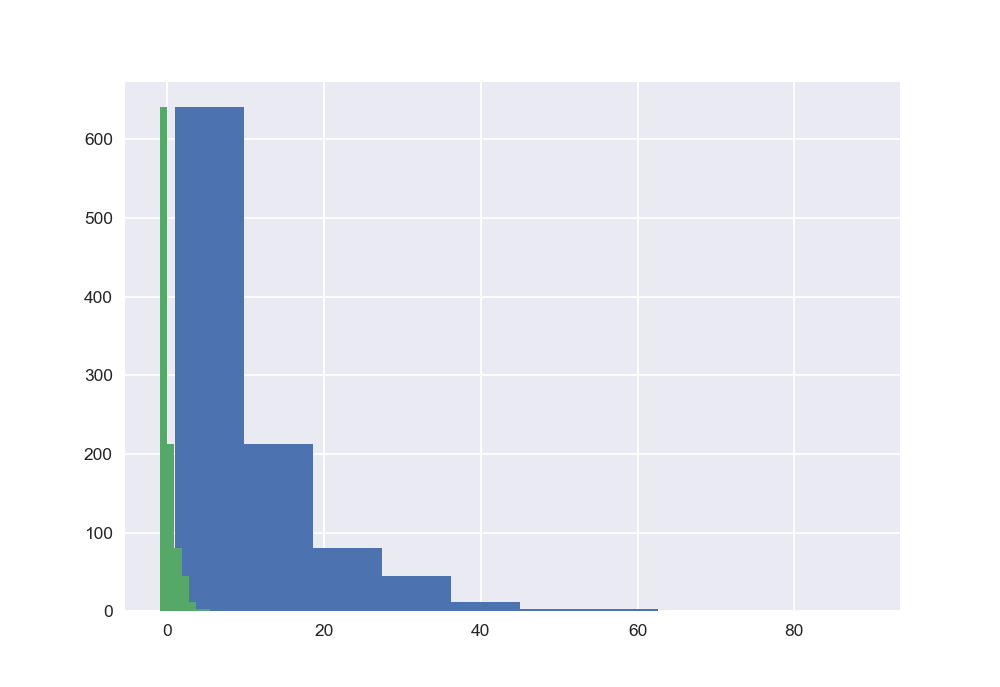

StandardScaler(copy=True, with_mean=True, with_std=True)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your dat

<IPython.core.display.Javascript object>


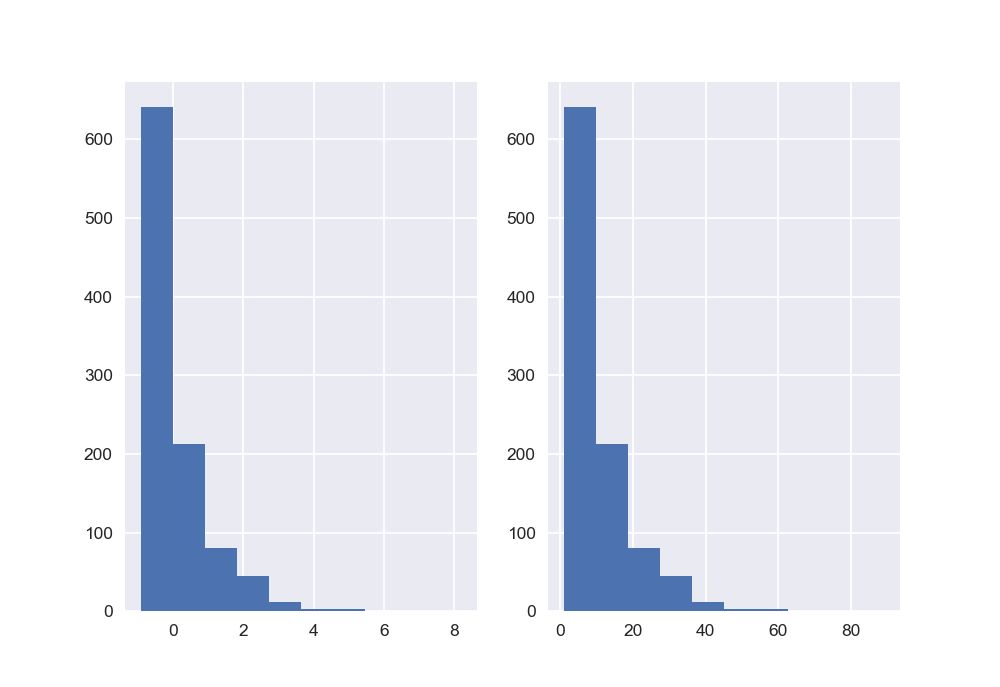

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(array([ 641.,  213.,   81.,   45.,   12.,    3.,    3.,    1.,    0.,    1.]),
 array([  1. ,   9.8,  18.6,  27.4,  36.2,  45. ,  53.8,  62.6,  71.4,
         80.2,  89. ]),
 <a list of 10 Patch objects>)

In [68]:
gaussian_numbers = np.random.geometric(0.1,1000) 

plt.hist(gaussian_numbers) 

print(scaler.fit(gaussian_numbers))
plt.hist(scaler.transform(gaussian_numbers))
# fig, ax = plt.subplots(2)
fig, axs = plt.subplots(1,2)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(scaler.transform(gaussian_numbers))
axs[1].hist(gaussian_numbers)
# axs[1].hist(y, bins=n_bins)

In [83]:
import tensorflow as tf


In [84]:
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0) # also tf.float32 implicitly
print(node1, node2)

Tensor("Const_4:0", shape=(), dtype=float32) Tensor("Const_5:0", shape=(), dtype=float32)


In [85]:
sess = tf.Session()
print(sess.run([node1, node2]))

[3.0, 4.0]


In [86]:
from __future__ import print_function
node3 = tf.add(node1, node2)
print("node3:", node3)
print("sess.run(node3):", sess.run(node3))

node3: Tensor("Add_2:0", shape=(), dtype=float32)
sess.run(node3): 7.0


SyntaxError: illegal target for annotation (<ipython-input-78-4f7818c47ca2>, line 2)